# Upload data

In [1]:
UPLOAD = True

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from metacatalog import api, models

## Load Metadata

connect

In [3]:
session = api.connect_database()

get the entries

In [4]:
entries = api.find_entry(session, title='CAOS *')
print('Have %d entries' % len(entries))

Have 2115 entries


## Infer correct entry from datafile location, filename and column

The CAOS data is organized by Cluster. The tracing should work as follows:

* top-level dir gives the site code to filter
* file-name can be used to filter the variable (but some vars go into the same file)
* column order either gives the variable or the variable and depth. This will be the main challenge
* some comments give a non-standard order

In [5]:
e = entries[165]
e.to_dict()

{'id': 189,
 'uuid': 'bb85223d-a6bc-4241-8261-22ed3d6b9cd8',
 'title': 'CAOS [807] - Temperature, soil 1.16.45.30.2.2.1.CL.SM.i',
 'author': {'id': 2,
  'first_name': 'Theresa',
  'last_name': 'Blume',
  'organisation_name': 'German Research Centre For Geosciences GFZ ',
  'affiliation': 'German Research Centre For Geosciences GFZ , Hydrology',
  'attribution': 'Data collected by GFZ as part of the CAOS project'},
 'authors': [{'id': 2,
   'first_name': 'Theresa',
   'last_name': 'Blume',
   'organisation_name': 'German Research Centre For Geosciences GFZ ',
   'affiliation': 'German Research Centre For Geosciences GFZ , Hydrology',
   'attribution': 'Data collected by GFZ as part of the CAOS project'}],
 'locationShape': 'POINT (5.833975 49.823242)',
 'location': 'POINT (5.833975 49.823242)',
 'variable': {'id': 2,
  'name': 'soil temperature',
  'symbol': 'Ts',
  'unit': {'id': 101, 'name': 'degree Celsius', 'symbol': 'C'}},
 'embargo': True,
 'embargo_end': datetime.datetime(2022, 7

In [6]:
%%cmd
python -m metacatalog find variable

Microsoft Windows [Version 10.0.17763.1339]
(c) 2018 Microsoft Corporation. Alle Rechte vorbehalten.

E:\Dropbox\KIT\projects\vforwater\scripts\caos>python -m metacatalog find variable
air temperature [C] <ID=1>
soil temperature [C] <ID=2>
water temperature [C] <ID=3>
discharge [m3/s] <ID=4>
air pressure [10^2*Pa] <ID=5>
relative humidity [%] <ID=6>
daily rainfall sum [mm/d] <ID=7>
rainfall intensity [mm/h] <ID=8>
solar irradiance [W/m2] <ID=9>
net radiation [W/m2] <ID=10>
gravimetric water content [kg/kg] <ID=11>
precision [-] <ID=13>
sap flow [cm^3/cm^2h] <ID=14>
volumetric water content [cm3/cm3] <ID=12>
matric potential [MPa] <ID=15>
bulk electrical conductivity [EC] <ID=16>
specific electrical conductivity [EC] <ID=17>
river water level [m] <ID=18>

E:\Dropbox\KIT\projects\vforwater\scripts\caos>

In [8]:
VM = {
    2: 'FiveTE.dat',
    12: 'FiveTE.dat',
    16: 'FiveTE.dat'    
}
COL = {
    'i': 1,
    'j': 2,
    'k': 3,
    'l': 4,
    'm': 5,
    'n': 6,
    'o': 7,
    'p': 8,
    'q': 9,
    'r': 10
}
COLNAME = {
    2: 'Temp5TE_C',
    12: 'VWC',
    16: 'EC'
}

# this is very specific
def get_folder(e: models.Entry):
    d = e.details_dict(full=True)
    site = d.get('site', {}).get('value')
    if site is None:
        return None
    else:
        chunks = site.split('.')
        CL = chunks[-2]
        s = CL[-1]
        CL = CL[0:2] if len(CL) == 3 else CL[0]
        return '%s_%s' % (CL.capitalize(), s.upper())

def get_file(e: models.Entry):
        fn = VM.get(e.variable.id)
        fo = get_folder(e)
        if fn is None or fo is None:
            return None
        fn = '%s_%s' % (fo, fn)
        return os.path.join(fo, fn)
    
def get_column(e: models.Entry):
    name = COLNAME.get(e.variable.id)
    d = e.details_dict(full=True)
    site = d.get('site', {}).get('value')
    if name is None or site is None:
        return None
    i = site.split('.')[-1]
    num = COL.get(i)
    if num is None:
        return None
    if e.variable_id in (2, 12, 16):
#        if 'n,m,l' in e.comment or 'q,p,o' in e.comment or 'k,j,i' in e.comment:
#            rev = True
#        else:
#            rev = False
        if d.get('depth', {}).get('value') == '50.0':
            num += 0
        if d.get('depth', {}).get('value') == '30.0':
            num += 1
        if d.get('depth', {}).get('value') == '10.0':
            num += 2
        if d.get('depth', {}).get('value') == '80.0':
            num = 10
    
    return "{name}_Avg.{num}.".format(name=name, num=num)

for i,e in enumerate([e for e in entries]):
    if i > 150 and i < 170:
        print(e.title, ':\t\t', get_column(e))

CAOS [228] - Temperature, soil 1.1.45.30.2.1.2.CL.SC.o :		 Temp5TE_C_Avg.8.
CAOS [284] - Temperature, soil 1.1.45.30.2.1.CL.SD.i :		 Temp5TE_C_Avg.2.
CAOS [287] - Temperature, soil 1.1.45.30.2.1.CL.SD.l :		 Temp5TE_C_Avg.5.
CAOS [290] - Temperature, soil 1.1.45.30.2.1.CL.SD.o :		 Temp5TE_C_Avg.8.
CAOS [349] - Temperature, soil 1.1.45.30.2.1.CL.SE.i :		 Temp5TE_C_Avg.2.
CAOS [346] - Temperature, soil 1.1.45.30.2.1.CL.SE.l :		 Temp5TE_C_Avg.5.
CAOS [352] - Temperature, soil 1.1.45.30.2.1.CL.SE.o :		 Temp5TE_C_Avg.8.
CAOS [411] - Temperature, soil 1.1.45.30.2.1.CL.SF.i :		 Temp5TE_C_Avg.2.
CAOS [414] - Temperature, soil 1.1.45.30.2.1.CL.SF.l :		 Temp5TE_C_Avg.5.
CAOS [470] - Temperature, soil 1.1.45.30.2.1.CL.SG.h :		 None
CAOS [588] - Temperature, soil 1.1.45.30.2.1.2.CL.SI.i :		 Temp5TE_C_Avg.2.
CAOS [594] - Temperature, soil 1.1.45.30.2.1.2.CL.SI.o :		 Temp5TE_C_Avg.8.
CAOS [999] - Temperature, soil 1.16.45.30.2.4.1.CL.SQ.o :		 Temp5TE_C_Avg.8.
CAOS [749] - Temperature, soil 1.16.45.30

## Test for entry ID=172

In [9]:
e = entries[150]
print('From DB')
print("-------------------------------------")
print(e.id)
print(e.title)
print(e.details_dict().get('depth').get('value'))
print(e.details_dict().get('name').get('value'))
print(e.comment)
print("-------------------------------------")
print("\n Infer:")
print('File:  ', get_file(e))
print('Column: ', get_column(e))

From DB
-------------------------------------
172
CAOS [225] - Temperature, soil 1.1.45.30.2.1.2.CL.SC.l
30.0
schist - cluster: S_C - forest - midslope - N
n,m,l
-------------------------------------

 Infer:
File:   S_C\S_C_FiveTE.dat
Column:  Temp5TE_C_Avg.5.


In [10]:
filename = os.path.join('data', get_file(e))
print(filename)
colname = get_column(e)

_dat = pd.read_csv(filename, sep='\s+')
_dat.index.name = 'DATE'
_dat.reset_index(inplace=True)
#_dat.index.name = 'tstamp'
if colname in _dat.columns:
    series = pd.Series(_dat[colname].copy())
    idx = pd.to_datetime(_dat[['DATE', 'TIMESTAMP']].apply(lambda r: '%s %s' % (r[0], r[1]), axis=1), format='%Y-%m-%d %H:%M:%S')
    series.index = idx
    series.index.name = 'tstamp'
    series.name = 'value'
else:
    print("Can't find column: ", colname)
series

data\S_C\S_C_FiveTE.dat


tstamp
2012-05-12 19:05:00    10.6
2012-05-12 19:10:00    10.6
2012-05-12 19:15:00    10.6
2012-05-12 19:20:00    10.6
2012-05-12 19:25:00    10.6
                       ... 
2015-01-13 14:20:00     5.0
2015-01-13 14:25:00     5.0
2015-01-13 14:30:00     5.0
2015-01-13 14:35:00     5.0
2015-01-13 14:40:00     5.0
Name: value, Length: 281036, dtype: float64

In [13]:
if UPLOAD and True:
    # create datasource
    if e.datasource is None:
        e.create_datasource(type=1, path='timeseries', datatype='timeseries', commit=True)
    
    # import data
    e.import_data(series.dropna())
    
    # add temporal scale
    e.datasource.create_scale(
        resolution='5min',
        extent=(series.index[0].to_pydatetime(), series.index[-1].to_pydatetime()),
        support=1.0,
        scale_dimension='temporal'
    )
    
    session.add(e)
    session.commit()
    print('Done ID=%d loaded %d points' % (e.id, len(series)))
    

Done ID=172 loaded 281036 points


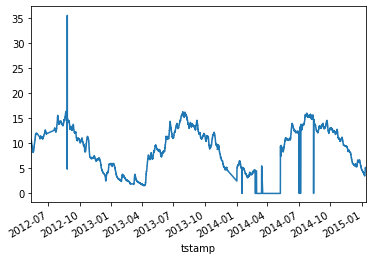

In [14]:
e.get_data()[e.variable.name].plot()

In [15]:
print(e.datasource.temporal_scale)

## Go for all

In [16]:
entries = api.find_entry(session, author='Blume')
print('Have %d entries' % len(entries))

Have 2115 entries


In [20]:
def convert_data(filename, colname):
    _dat = pd.read_csv(filename, sep='\s+', error_bad_lines=False)
    _dat.index.name = 'DATE'
    _dat.reset_index(inplace=True)
    if colname in _dat.columns:
        series = pd.Series(_dat[colname].copy())
        idx = pd.to_datetime(_dat[['DATE', 'TIMESTAMP']].apply(lambda r: '%s %s' % (r[0], r[1]), axis=1), format='%Y-%m-%d %H:%M:%S')
        series.index = idx
        series.index.name = 'tstamp'
        series.name = 'value'
    else:
        print("Can't find column: ", colname)
        return None
    return series

In [22]:
batch = 20
uploaded = 0
if UPLOAD and True:
    for i,e in enumerate(entries):
        if uploaded == batch:
            print('Reached batch limit of %d' % batch)
            break
        # create datasource
        if e.datasource is None:
            e.create_datasource(type=1, path='timeseries', datatype='timeseries', commit=True)
    
        # import data
        if e.datasource.temporal_scale is None:
            fn = get_file(e)
            colname = get_column(e)
            if fn is None or colname is None:
                continue
            filename = os.path.join('data', get_file(e))
            print('Processing Column: %s in file %s...' % (colname, filename), end='')
            try:
                series = convert_data(filename, colname)
            except Exception as e:
                print('Error.')
                continue
                
            print('done.\t', end='')

            e.import_data(series.dropna())
    
            # add temporal scale
            e.datasource.create_scale(
                resolution='5min',
                extent=(series.index[0].to_pydatetime(), series.index[-1].to_pydatetime()),
                support=1.0,
                scale_dimension='temporal'
            )
    
            session.add(e)
            session.commit()
            uploaded += 1
            print('ID=%d loaded %d points.' % (e.id, len(series)))
        else:
            print('ID=%d has already data.' % e.id)

ID=187 has already data.
ID=188 has already data.
ID=189 has already data.
ID=190 has already data.
ID=191 has already data.
ID=192 has already data.
ID=193 has already data.
ID=198 has already data.
ID=199 has already data.
ID=210 has already data.
ID=211 has already data.
ID=213 has already data.
ID=214 has already data.
Processing Column: Temp5TE_C_Avg.2. in file data\M_B\M_B_FiveTE.dat...

b'Skipping line 180222: expected 32 fields, saw 43\n'
b'Skipping line 180426: expected 32 fields, saw 37\nSkipping line 185290: expected 32 fields, saw 44\nSkipping line 187114: expected 32 fields, saw 35\n'


Error.
Processing Column: Temp5TE_C_Avg.5. in file data\M_B\M_B_FiveTE.dat...

b'Skipping line 180222: expected 32 fields, saw 43\n'
b'Skipping line 180426: expected 32 fields, saw 37\nSkipping line 185290: expected 32 fields, saw 44\nSkipping line 187114: expected 32 fields, saw 35\n'


Error.
Processing Column: Temp5TE_C_Avg.2. in file data\M_D\M_D_FiveTE.dat...done.	ID=220 loaded 141829 points.
Processing Column: Temp5TE_C_Avg.5. in file data\M_I\M_I_FiveTE.dat...done.	ID=233 loaded 177648 points.
Processing Column: Temp5TE_C_Avg.8. in file data\M_I\M_I_FiveTE.dat...done.	ID=234 loaded 177648 points.
Processing Column: Temp5TE_C_Avg.2. in file data\Sa_E\Sa_E_FiveTE.dat...done.	ID=256 loaded 140518 points.
Processing Column: Temp5TE_C_Avg.2. in file data\Sa_F\Sa_F_FiveTE.dat...done.	ID=257 loaded 140208 points.
Processing Column: Temp5TE_C_Avg.5. in file data\Sa_F\Sa_F_FiveTE.dat...done.	ID=258 loaded 140208 points.
Processing Column: Temp5TE_C_Avg.8. in file data\Sa_F\Sa_F_FiveTE.dat...done.	ID=259 loaded 140208 points.
Processing Column: Temp5TE_C_Avg.8. in file data\Sa_G\Sa_G_FiveTE.dat...done.	ID=261 loaded 150336 points.
Processing Column: Temp5TE_C_Avg.5. in file data\Sa_H\Sa_H_FiveTE.dat...done.	ID=263 loaded 157228 points.
Processing Column: Temp5TE_C_Avg.8. 